## Importamos las librerias necesarias

vamos a comenzar por importar todas las librerias y modulos necesarios para trabajar a lo largo de la practica

In [3]:
import os.path
from shutil import unpack_archive
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import ast
import requests

2023-05-17 12:55:42.551398: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 12:55:42.951493: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 12:55:42.952832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 12:55:44.573092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Configuracion de plt

Setemos unas configuraciones basicas para matplotlib,como el estilo,dimensiones y resolucion de las imagenes

In [4]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

## Cargando el Embedding

Descomprimimos los embeddings pre-entrenados de GloVe en el directorio /tmp. Ademas indicaremos donded esta el fichero de keywords que nos servira mas adelante para configurar la salida de nuestro modelo 

In [5]:
GLOVE_FILE = 'tmp/glove.6B.zip'
GLOVE_DIR = './tmp/'
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'

KEYWORDS_FILE = 'keywords.json'

if not os.path.isdir(GLOVE_DIR):
    os.makedirs(GLOVE_DIR)
    
# Descargamos el dataset comprimido de GloVe
if not os.path.exists(GLOVE_FILE):
    print('Downloading ...', end='')
    with open(GLOVE_FILE, 'wb') as f:
        r = requests.get(GLOVE_URL, allow_redirects=True)
        f.write(r.content)
    print('OK')
print('Unpacking ...', end='')
unpack_archive(GLOVE_FILE, GLOVE_DIR)
print('OK')

Unpacking ...OK


## Parametros del Embedding

definimos la dimension del embeding a utilizar, la dimension maxima del vocabulario y el numero maximo de palabras permitidas en una secuencia

In [6]:
# Cuántas dimensiones tienen nuestros word vectors (50, 100, 200 o 300)
EMBEDDING_DIM = 50
# El tamaño máximo de nuestro vocabulario (se escogerán las más frecuentes)
MAX_VOCAB_SIZE = 10000
# El tamaño de la frase más larga con la que alimentar el modelo
MAX_SEQUENCE_LENGTH = 100

## Creacion del embeding

vamos a cargar en memoria un hash map conn la informacion del embedding, donde la clave sera la palabra y el valor sera el vector de caracteristicas asociado a la palabra

In [7]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt')) as f:
    for line in f:
        values = line.split()
        word2vec[values[0]] = np.asarray(values[1:], dtype='float32')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 50-d embedding... done (400000 word vectors loaded)


## Carga de los datos

cargamos los abstracts y los keywords en memoria a partir del fichero .csv, vamos a obviar los titulos ya que no son necesarios para nuestro modelo.

Como se trata de un problema de aprendizaje supervisado, nuestras etiquetas en este caso seran conjuntos de palabras claves.

In [8]:
print('Loading dataset... ', end='')
df = pd.read_csv('papers.csv')
abstracts = df['abstract'].values
targets = np.array([ast.literal_eval(value) for value in df['keywords'].values],dtype=object)
print(f'done ({len(abstracts)} comments loaded)')
print(f'Biggest abstract length:  {max(len(s) for s in abstracts)}')
print(f'Smallest abstract length: {min(len(s) for s in abstracts)}')
print(f'Avg. abstract length:     {np.mean([len(s) for s in abstracts])}')
print(f'Median abstract length:   {sorted(len(s) for s in abstracts)[len(abstracts) // 2]}')
print('-' * 20)
print(f'Example comment: {abstracts[12]}')
print(f'Example targets: {targets[12]}')

Loading dataset... done (4555 comments loaded)
Biggest abstract length:  2962
Smallest abstract length: 10
Avg. abstract length:     1120.9345773874863
Median abstract length:   1079
--------------------
Example comment: Object tracking is an important task within the field of computer vision. Tracking accuracy depends mainly on finding good discriminative features to estimate the target location. In this paper, we introduce online feature learning in tracking and propose to learn good features to track generic objects using online convolutional neural networks (OCNN). OCNN has two feature mapping layers that are trained offline based on unlabeled data. In tracking, it is also augmented with a classifier to provide a decision. In order to learn discriminative and stable features for tracking, we propose a novel object function to train OCNN by penalizing the feature variations in consecutive frames. We build a tracking system by combining OCNN and a color-based multi-appearance model. 

## Tokenizacion de las cadenas

vamos a tokenizar las cadenas de texto de los abstracts, para ello vamos a utilizar la clase Tokenizer de Keras, esto nos permitira convertir las cadenas de texto en secuencias de enteros (cada entero representa un token en el texto) usando como limite el numero maximo de palabras permitidas en nuestro vocabulario

In [9]:
tokenizer =   tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(abstracts)
sequences =   tokenizer.texts_to_sequences(abstracts)
word_index =  tokenizer.word_index

print(f'Biggest index: {max(max(seq) for seq in sequences if len(seq) > 0)}')
print(f'Unique tokens: {len(word_index)}')
print('-' * 20)
print(f'Example comment: {abstracts[7]}: {sequences[7]}')

Biggest index: 9999
Unique tokens: 19882
--------------------
Example comment: Reinforcement learning techniques become more popular in computer network security. The same reinforcement learning techniques developed for network security can be applied to software security as well. This research summarizes a work in progress attempt to incorporate Q-learning algorithm in software security. The Q-learning method is embedded as part of the software itself to provide a security mechanism that has ability to learn by itself to develop a temporary repair mechanism. The results of the experiment express that given the right parameters and the right setting the Q-learning approach rapidly learns to block all alicious actions. Data analysis on the Q-values produced by the software can provide security diagnostic as well. A larger scale experiment is expected to be seen in the future work.: [545, 19, 54, 400, 68, 479, 5, 374, 24, 101, 1, 303, 545, 19, 54, 226, 8, 24, 101, 25, 23, 181, 4, 230, 10

## Padding

Como las entradas de nuestra red deben ser todas del mismo tamano y como nuestras secuencias no son todas del mismo tamano debemos rellenar con 0 las secuencias mas cortas para que todas tengan la misma longitud

In [10]:
data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    value=0,
    maxlen=MAX_SEQUENCE_LENGTH
)
print(f'Data tensor shape: {data.shape}')
print(
  f'Example padded abstract: {abstracts[2]}: {data[2]}'
)

Data tensor shape: (4555, 100)
Example padded abstract: Number of defects remaining in a system provides an insight into the quality of the system. Defect detection systems predict defects by using software metrics and data mining techniques. Clustering analysis is adopted to build the software defect prediction models. Cluster ensembles have emerged as a prominent method for improving robustness, stability and accuracy of clustering solutions. The clustering ensembles combine multiple partitions generated by different clustering algorithms into a single clustering solution. In this paper, the clustering ensemble using Particle Swarm Optimization algorithm (PSO) solution is proposed to improve the predict quality. An empirical study shows that the PSO can be a good choice to build defect prediction software  models.: [   1  160    2    1   48 2448   74   49  272 2279   18   29  230  381
    3   15  347   54  150   75    7 1032    4  658    1  230 2448  106
   42  651 1620   32 1376   1

## Carga del Embedding

vamos a crear una matriz de pesos para nuestro modelo, donde cada fila sera un vector de caracteristicas asociado a una palabra de nuestro vocabulario, para ello vamos a recorrer el hash map que hemos creado anteriormente y vamos a ir rellenando la matriz de pesos con los vectores de caracteristicas de cada palabra

In [11]:
print('Loading embedding with GloVe vectors... ', end='')
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


print('done')

Loading embedding with GloVe vectors... done


## Creacion de la capa de embedding

Keras nos facilita una abstraccion en forma de capa para manejar los embeddings de una forma mas sencilla, esta capa se encargara de convertir los enteros que representan las palabras en vectores de caracteristicas

In [12]:
# Creamos la capa de embedding
embedding_layer = tf.keras.layers.Embedding(
  input_dim=num_words,
  output_dim=EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False,
)

## Ajustando los datos de salida

vamos a ajustar nuestros targets para que se ajusten a nuestro modelo de tal forma que cada palabra clave sea un vector de 0 y 1, de una dimension igual a la cantidad total de palabras claves, donde 1 indicara el indice de la palabra clave en el vocabulario, y el resto se rellena con 0.

In [13]:

print(f'loading keywords from {KEYWORDS_FILE}... ', end='')
with open(KEYWORDS_FILE,'r') as f:
    keywords = json.load(f)

print(f'done ({len(keywords)} keywords loaded)')

    
keyword_to_index = {word: index for index, word in enumerate(keywords)}
print(f'keyword_to_index: {keyword_to_index}')

for i, target in enumerate(targets):
    for keyword in target:
        try:
            keyword_to_index[keyword]
        except KeyError:
            keyword_to_index[keyword] = len(keyword_to_index)

indexed_targets = np.zeros((len(targets), len(keyword_to_index)))

for i, target in enumerate(targets):
    for keyword in target:
        try:
            indexed_targets[i][keyword_to_index[keyword]] = 1
        except KeyError:
            print(f'keyerror on target {i}:{target}, key tried:{keyword}')

print(f'indexed_targets shape: {indexed_targets.shape}, example: {indexed_targets[0]}')

loading keywords from keywords.json... done (3360 keywords loaded)
keyword_to_index: {'2d': 0, '3d': 1, '3g mobile communication': 2, '3gpp': 3, '4d': 4, '5g': 5, '6g mobile communication': 6, 'accidents': 7, 'active appearance model': 8, 'active filters': 9, 'active learning': 10, 'actuators': 11, 'ad hoc networks': 12, 'adaptive': 13, 'additive noise': 14, 'additives': 15, 'adhesives': 16, 'admission control': 17, 'adversarial': 18, 'advertising': 19, 'aerodynamics': 20, 'aerospace': 21, 'aggregates': 22, 'aircrafts': 23, 'algorithm design and analysis': 24, 'all-optical networks': 25, 'american sign language': 26, 'amino acids': 27, 'amplitude modulation': 28, 'anaemia': 29, 'analog-digital conversion': 30, 'analysis of variance': 31, 'analytical models': 32, 'anatomy': 33, 'anchored synchronization': 34, 'android': 35, 'androids': 36, 'angular velocity': 37, 'animal structures': 38, 'animals': 39, 'animation': 40, 'anisotropic magnetoresistance': 41, 'annealing': 42, 'annotations':

# CNN

In [14]:
input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))

x = embedding_layer(input_)
x = tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)

output = tf.keras.layers.Dense(len(keyword_to_index), activation='linear')(x)

model = tf.keras.Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['binary_accuracy'],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           500000    


2023-05-17 12:56:09.786152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-17 12:56:09.786591: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


                                                                 
 conv1d (Conv1D)             (None, 98, 16)            2416      
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 32)            1568      
                                                                 
 conv1d_2 (Conv1D)           (None, 94, 64)            6208      
                                                                 
 dropout (Dropout)           (None, 94, 64)            0         
                                                                 
 flatten (Flatten)           (None, 6016)              0         
                                                                 
 dense (Dense)               (None, 16)                96272     
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (

## Entrenamiento del modelo

In [15]:
history = model.fit(data, indexed_targets, epochs=50, validation_split=0.1, batch_size=4096)

Epoch 1/50


2023-05-17 12:56:10.111504: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56517012 exceeds 10% of free system memory.
2023-05-17 12:56:11.582167: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56475648 exceeds 10% of free system memory.
2023-05-17 12:56:11.582569: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56475648 exceeds 10% of free system memory.
2023-05-17 12:56:11.583069: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56475648 exceeds 10% of free system memory.
2023-05-17 12:56:11.583361: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 56475648 exceeds 10% of free system memory.


2/2 [==============================] - 3s 291ms/step - loss: 0.0253 - binary_accuracy: 0.9981 - val_loss: 0.0329 - val_binary_accuracy: 0.9972
Epoch 2/50
2/2 [==============================] - 1s 103ms/step - loss: 0.0216 - binary_accuracy: 0.9981 - val_loss: 0.0309 - val_binary_accuracy: 0.9972
Epoch 3/50
2/2 [==============================] - 1s 76ms/step - loss: 0.0183 - binary_accuracy: 0.9981 - val_loss: 0.0298 - val_binary_accuracy: 0.9972
Epoch 4/50
2/2 [==============================] - 1s 57ms/step - loss: 0.0174 - binary_accuracy: 0.9981 - val_loss: 0.0292 - val_binary_accuracy: 0.9972
Epoch 5/50
2/2 [==============================] - 1s 98ms/step - loss: 0.0169 - binary_accuracy: 0.9981 - val_loss: 0.0288 - val_binary_accuracy: 0.9972
Epoch 6/50
2/2 [==============================] - 1s 53ms/step - loss: 0.0165 - binary_accuracy: 0.9981 - val_loss: 0.0284 - val_binary_accuracy: 0.9972
Epoch 7/50
2/2 [==============================] - 1s 55ms/step - loss: 0.0163 - binary_accu

## Visualizacion del entrenamiento

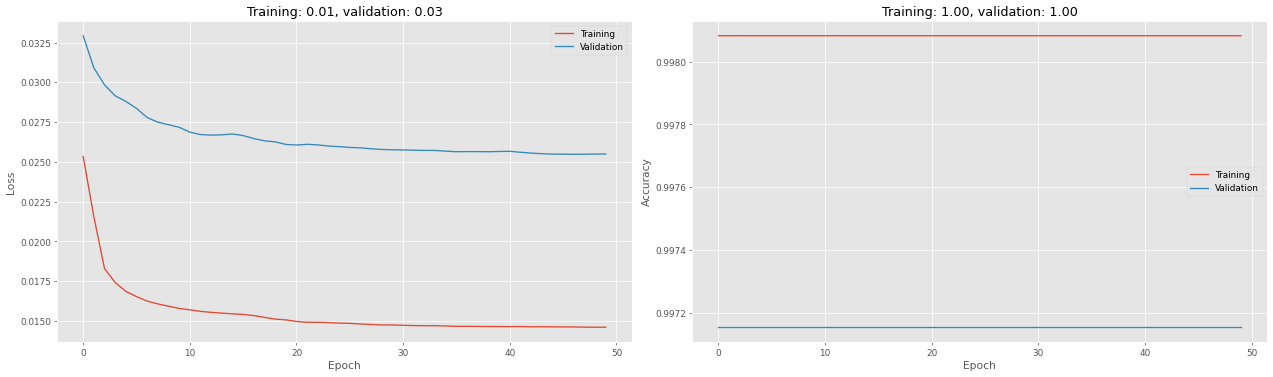

Abstract: Statistical word alignment models need large amount of training data while they are weak in small-size corpora. This paper proposes a new approach of unsupervised hybrid word alignment technique using ensemble learning method. This algorithm uses three base alignment models in several rounds to generate alignments. The ensemble algorithm uses a weighed scheme for resampling training data and a voting score to consider aggregated alignments. The underlying alignment algorithms used in this study include IBM Model 1, 2 and a heuristic method based on Dice measurement. Our experimental results show that by this approach, the alignment error rate could be improved by at least %15 for the base alignment models.
Targets: ['ensemble learning', 'word alignment']
Top 5 weights: [0.04294269, 0.039582673, 0.037250638, 0.036241863, 0.035708472]
words indexes: [3378, 3430, 939, 1599, 3091]
words: ['neural networks', 'protocols', 'feature extraction', 'machine learning', 'training']
---
Ab

In [16]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training: {history.history["loss"][-1]:.2f}, validation: {history.history["val_loss"][-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training')
plt.plot(history.history['val_binary_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training: {history.history["binary_accuracy"][-1]:.2f}, validation: {history.history["val_binary_accuracy"][-1]:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

#!Algunos ejemplos con las mejores 5 predicciones
for i in range(5):
    print(f'Abstract: {abstracts[i]}')
    print(f'Targets: {targets[i]}')
    
    prediction = model.predict(data[i:i+1],verbose=0)[0]
    top5 = np.argsort(prediction)[-5:]
    
    print(f'Top 5 weights: {sorted(prediction)[-5:][::-1]}')
    print(f'words indexes: {[list(keyword_to_index.values()).index(index) for index in top5]}')
    print(f'words: {[list(keyword_to_index.keys())[list(keyword_to_index.values()).index(index)] for index in top5]}')
    print('---')

## Guardamos el modelo

In [17]:
model.save('./tmp/NLP-CNN.h5')

## RNN
vamos a realizar el mismo procedimiento pero ahora utilizando redes recurrentes para inferir las keywords

In [18]:
input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = tf.keras.layers.GRU(128)(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(len(keyword_to_index), activation='linear')(x)

model = tf.keras.Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['binary_accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           500000    
                                                                 
 gru (GRU)                   (None, 128)               69120     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3447)              444663    
                                                                 
Total params: 1,013,783
Trainable params: 513,783
Non-trainable params: 500,000
_________________________________________________________________


2023-05-17 12:57:01.367046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 12:57:01.368865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 12:57:01.370530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## Entrenamiento del modelo

In [19]:
history = model.fit(data,indexed_targets, epochs=50, validation_split=0.1, batch_size=512)

Epoch 1/50


2023-05-17 12:57:01.727254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 12:57:01.729572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 12:57:01.731633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 0.0300 - binary_accuracy: 0.9981

2023-05-17 12:57:05.684908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 12:57:05.686573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 12:57:05.688320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 4s 306ms/step - loss: 0.0300 - binary_accuracy: 0.9981 - val_loss: 0.0348 - val_binary_accuracy: 0.9972
Epoch 2/50
9/9 [==============================] - 2s 269ms/step - loss: 0.0209 - binary_accuracy: 0.9981 - val_loss: 0.0345 - val_binary_accuracy: 0.9972
Epoch 3/50
9/9 [==============================] - 2s 272ms/step - loss: 0.0204 - binary_accuracy: 0.9981 - val_loss: 0.0342 - val_binary_accuracy: 0.9972
Epoch 4/50
9/9 [==============================] - 2s 271ms/step - loss: 0.0202 - binary_accuracy: 0.9981 - val_loss: 0.0343 - val_binary_accuracy: 0.9972
Epoch 5/50
9/9 [==============================] - 2s 277ms/step - loss: 0.0203 - binary_accuracy: 0.9981 - val_loss: 0.0341 - val_binary_accuracy: 0.9972
Epoch 6/50
9/9 [==============================] - 3s 277ms/step - loss: 0.0199 - binary_accuracy: 0.9981 - val_loss: 0.0338 - val_binary_accuracy: 0.9972
Epoch 7/50
9/9 [==============================] - 2s 266ms/step - loss: 0.0197 - binary

## Salvamos el modelo

In [20]:
model.save('./tmp/NLP-GRU.h5')

## Visualizamos el entrenamiento

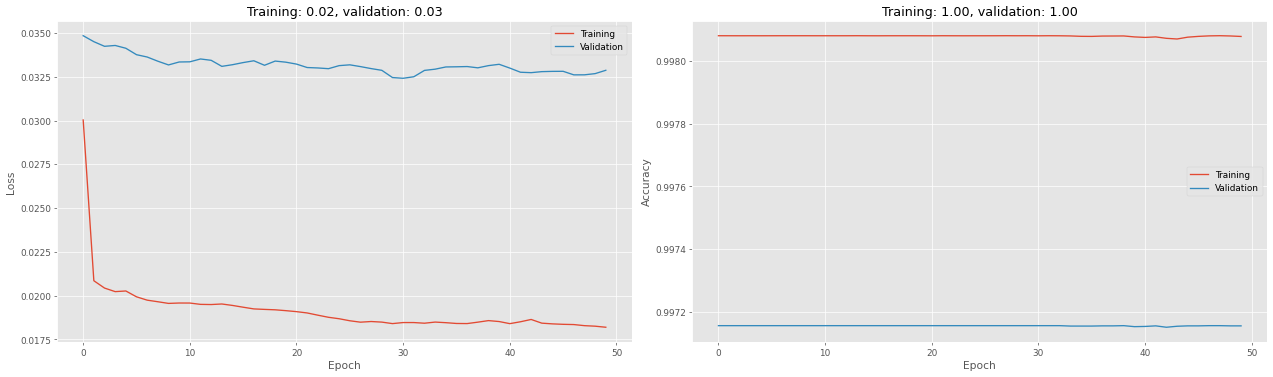

Abstract: Statistical word alignment models need large amount of training data while they are weak in small-size corpora. This paper proposes a new approach of unsupervised hybrid word alignment technique using ensemble learning method. This algorithm uses three base alignment models in several rounds to generate alignments. The ensemble algorithm uses a weighed scheme for resampling training data and a voting score to consider aggregated alignments. The underlying alignment algorithms used in this study include IBM Model 1, 2 and a heuristic method based on Dice measurement. Our experimental results show that by this approach, the alignment error rate could be improved by at least %15 for the base alignment models.
Targets: ['ensemble learning', 'word alignment']


2023-05-17 12:59:08.811196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 12:59:08.813432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 12:59:08.814828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Top 5 weights: [0.2627427, 0.22387075, 0.1750465, 0.17184675, 0.15752302]
words indexes: [3378, 3384, 1939, 3091, 3394]
words: ['neural networks', 'time series', 'neurons', 'training', 'fingerprint']
---
Abstract: Spectral learning algorithms learn an unknown function by learning a spectral (e.g., Fourier) representation of the function. However, there are many possible spectral representations, none of which will be best in all situations. Consequently, it seems natural to consider how a spectral learner could make use of multiple representations when learning. This paper proposes and compares three approaches to learning from multiple spectral representations. Empirical results suggest that an ensemble approach to multi-spectrum learning, in which spectral models are learned independently in each of a set of candidate representations and then combined in a majority-vote ensemble, works best in practice.
Targets: ['basis selection', 'discrete fourier', 'ensemble', 'representation', 's

In [21]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training: {history.history["loss"][-1]:.2f}, validation: {history.history["val_loss"][-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training')
plt.plot(history.history['val_binary_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training: {history.history["binary_accuracy"][-1]:.2f}, validation: {history.history["val_binary_accuracy"][-1]:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

#!Algunos ejemplos con las mejores 5 predicciones
for i in range(5):
    print(f'Abstract: {abstracts[i]}')
    print(f'Targets: {targets[i]}')
    
    prediction = model.predict(data[i:i+1],verbose=0)[0]
    top5 = np.argsort(prediction)[-5:]
    
    print(f'Top 5 weights: {sorted(prediction)[-5:][::-1]}')
    print(f'words indexes: {[list(keyword_to_index.values()).index(index) for index in top5]}')
    print(f'words: {[list(keyword_to_index.keys())[list(keyword_to_index.values()).index(index)] for index in top5]}')
    print('---')